In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, CustomJS, Div, Select, Label
from bokeh.models.tools import TapTool
from bokeh.transform import factor_cmap, factor_mark
from bokeh.layouts import row, column

## Import and format the data

In [2]:
# import the data
data = pd.read_csv("ss21_processed_solutions/m0_feature_data.csv")
specific_solutions = pd.read_csv("ss21_processed_solutions/optimised_feature_data.csv")
tests = pd.read_csv("ss21_processed_solutions/tests_data.csv")
# drop the non-continuous features and format the data
data = data.drop(["used_boolean", "used_List", "used_Integer", "used_Point", "used_ArrayList", "used_StringBuilder"], axis=1)
specific_solutions = specific_solutions.drop(["used_boolean", "used_List", "used_Integer", "used_Point", "used_ArrayList", "used_StringBuilder"], axis=1)
tests["num_tests_passed"] = tests[["test_1", "test_2", "hidden_test_1", "hidden_test_2"]].sum(axis=1)
tests["%_tests_passed"] = tests["num_tests_passed"]/4*100
# format the source names
data["source"] = data["source"].replace({"bard":"Bard", "gpt3.5":"ChatGPT-3.5", "bing":"Bing", "gpt4":"ChatGPT-4", "student":"Human"})
tests["source"] = tests["source"].replace({"bard":"Bard", "gpt3.5":"ChatGPT-3.5", "bing":"Bing", "gpt4":"ChatGPT-4", "student":"Human"})
data["source"] = pd.Categorical(data["source"], ["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"])
# create interactions data
interactions_data = data.merge(tests, on=["name", "source", "style", "version"])
interactions_data = interactions_data[(interactions_data["num_tests_passed"]!=4) & (interactions_data["source"]!="Human")]
interactions_data["source"] = pd.Categorical(interactions_data["source"], ["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4"])
interactions_data = interactions_data.sort_values("source").reset_index(drop=True)
# format names
data["name"] = data["name"].str.replace("student", "")
data["name"] = data["source"].astype(str) + "_" + data["name"]
data.loc[data["source"]=="Bing", "name"] = data[data["source"]=="Bing"]["name"] + "_" + data[data["source"]=="Bing"]["version"]
data["code"] = data["code"].str.replace("\n", "<br>")
# create binary AI vs human data for the classifier - 1 is human, 0 is ai
data["binary_source"] = data["source"].apply(lambda row: 1 if row=="Human" else 0)

In [3]:
# give the columns human-readable names
new_col_names = ["source", "milestone", "name", "style", "version", "code", "Number of characters", "Number of lines", "Average line length", "Maximum line length", "Number of (scaled) comments", 
                "Number of (scaled) if statements", "Number of (scaled) for loops", "Number of (scaled) switch statements", 
                "Number of (scaled) digits", "Number of (scaled) exceptions thrown", "Number of (scaled) empty lines", 
                 "Number of (scaled) whitespace", "Number of (scaled) indents",
                "Number of (scaled) print statements", "Proportion of spaces around assignment operators", "Number of (scaled) files", 
                "Number of (scaled) method declarations", "Number of (scaled) field variables declared", "Number of (scaled) local variables declared", 
                "Number of (scaled) classes", "Number of (scaled) variables referenced", "Number of (scaled) method invocations", 
                "Number of (scaled) imports", "Average variable name length", "Maximum variable name length", "Average comment length", "Maximum comment length",
                "Edit distance (scaled)", "Difference in number of characters", "Difference in number of lines", "Difference in average line length", 
                 "Difference in maximum line length", "Difference in number of (scaled) empty lines", "Difference in number of (scaled) whitespace", 
                 "Difference in number of (scaled) indents", "binary_source"]

int_new_col_names = ["source", "milestone", "name", "style", "version", "code", "Number of characters", "Number of lines", "Average line length", "Maximum line length", "Number of comments", 
                "Number of if statements", "Number of for loops", "Number of switch statements", 
                "Number of digits", "Number of exceptions thrown", "Number of empty lines",
                "Number of print statements", "Proportion of spaces around assignment operators", "Number of files", "Number of whitespace", "Number of indents",
                "Number of method declarations", "Number of field variables declared", "Number of local variables declared", 
                "Number of classes", "Number of variables referenced", "Number of method invocations", 
                "Number of imports", "Average variable name length", "Maximum variable name length", "Average comment length", "Maximum comment length",
                "Edit distance", "Difference in number of characters", "Difference in number of lines", "Difference in average line length", 
                 "Difference in maximum line length", "Difference in number ofempty lines", "Difference in number of whitespace", 
                 "Difference in number of indents", "test_1", "test_2", "hidden_test_1", "hidden_test_2", "num_tests_passed", "%_tests_passed"]
data.columns = new_col_names
specific_solutions.columns = new_col_names[:-1]
interactions_data.columns = int_new_col_names

In [4]:
# additional information for the plots
colours = {"Human": (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
           "Bard": (1.0, 0.8509803921568627, 0.1843137254901961),
           "Bing": (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
           "ChatGPT-3.5": (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
           "ChatGPT-4": (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)}
colour_palette = ["#e5c949", "#e99675", "#95a3c3", "#a2c865", "#db96c0"]
aspects = [value for value in list(data.columns[6:-1]) if "used" not in value]
int_aspects = ["Number of exceptions thrown", "Average comment length", "Number of comments", "Number of field variables declared",
           "Number of local variables declared", "Average line length", "Average variable name length", "Number of switch statements", 
           "Number of variables referenced", "Number of lines", "Number of if statements", "Maximum variable name length",
           "Number of digits", "Number of classes", "Maximum line length", "Number of method declarations"]

## Correlations between the features

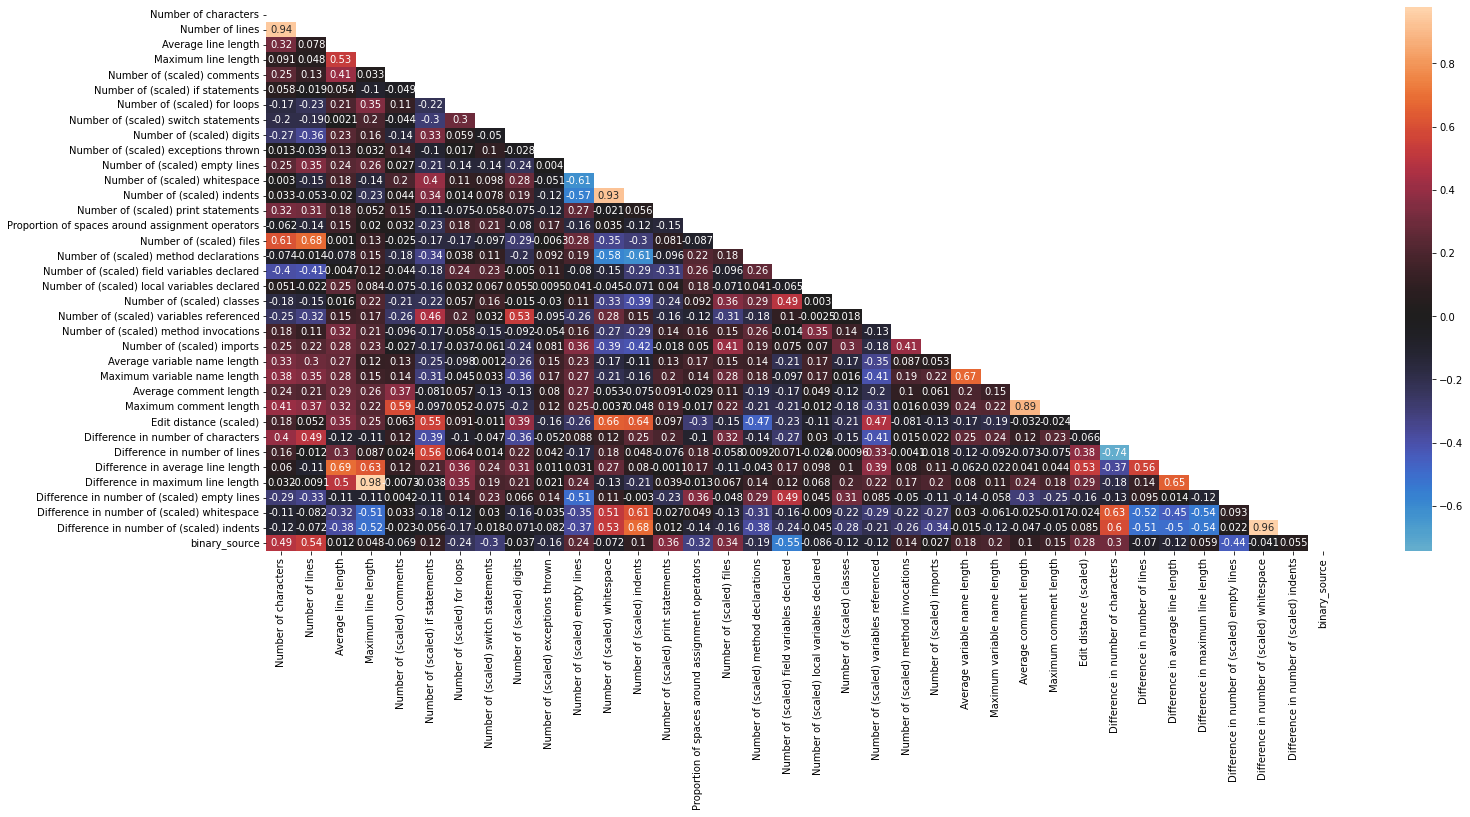

In [7]:
plt.subplots(figsize=(24, 10))
sns.heatmap(data.corr(), center=0, annot=True, mask=np.triu(np.ones_like(data.corr(), dtype=bool)));

## Differences on single features

In [7]:
plt.rcParams.update({"font.size": 14})

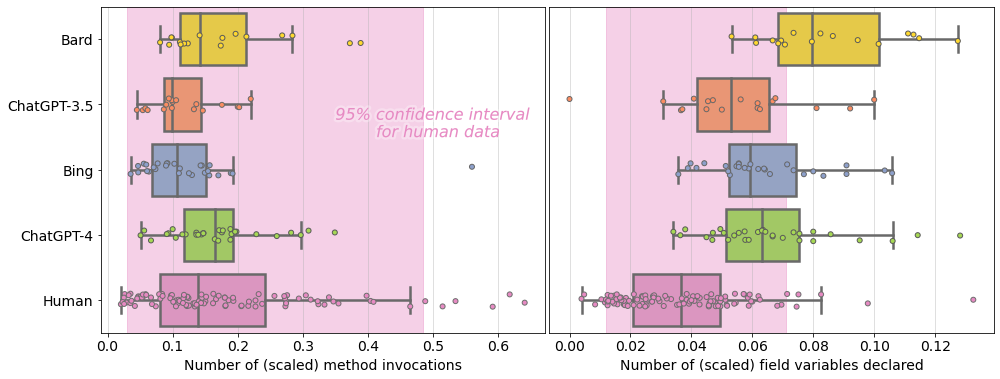

In [8]:
two_aspects=["Number of (scaled) method invocations", "Number of (scaled) field variables declared"]

# create the plot
fig, axes = plt.subplots(ncols=2, 
                         nrows=1, 
                         figsize=(16, 6))
fig.subplots_adjust(wspace=0.01)

# plot each of the features
for ax, aspect in zip(axes, two_aspects):
    
    # create the box plots
    sns.boxplot(data=data, 
                x=aspect, 
                y="source", 
                linewidth=2.5, 
                zorder=5, 
                palette=colours, 
                showfliers=False,
                order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"], 
                capprops={"color":"dimgray"}, 
                boxprops={'edgecolor':'dimgray'}, 
                medianprops={'color':'dimgray'}, 
                whiskerprops={'color':'dimgray'},
                ax=ax)
    
    # overlay with the stripplots
    sns.stripplot(data=data, 
                  x=aspect, y="source", 
                  hue="source", 
                  palette=colours, 
                  edgecolor='gray', 
                  linewidth=1,
                  zorder=10,
                  order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"], 
                  ax=ax)
    
    # adjust the labels
    ax.set_axisbelow(True)
    ax.set_ylabel("")
    ax.get_legend().remove()
    ax.grid(alpha=0.5, axis="x")
    
    # create a band for the confidence interval
    ax.axvspan(np.percentile(data[data["source"]=="Human"][aspect], 5), 
               np.percentile(data[data["source"]=="Human"][aspect], 95),
               alpha=0.4, 
               color=colours["Human"], 
               zorder=-5)
    
# label the confidence interval
axes[0].text(x=0.35, 
             y=1.5, 
             s="95% confidence interval\n        for human data", 
             size=16, 
             color=colours["Human"], 
             fontstyle="italic",
             path_effects=[pe.withStroke(linewidth=5, 
                                         foreground="white", 
                                         alpha=0.3)])
axes[1].set_yticks([]);

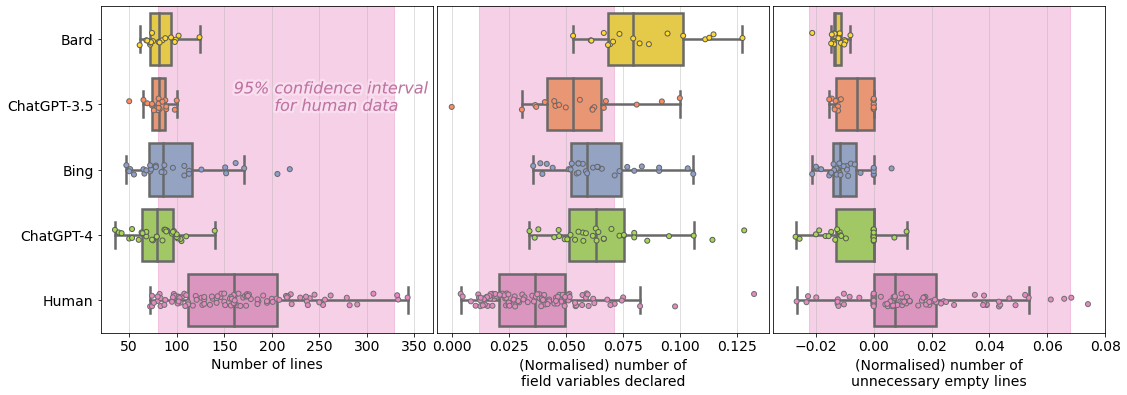

In [27]:
data["Difference in number of (scaled) empty lines"] = -data["Difference in number of (scaled) empty lines"]
data = data.rename(columns={"Difference in number of (scaled) empty lines":"Number of (scaled) unnecessary empty lines"})
three_aspects=["Number of lines", "Number of (scaled) field variables declared", "Number of (scaled) unnecessary empty lines"]
# create the plot
fig, axes = plt.subplots(ncols=3, 
                         nrows=1, 
                         figsize=(18, 6))
fig.subplots_adjust(wspace=0.01)

# plot each of the features
for ax, aspect in zip(axes, three_aspects):
    
    # create the box plots
    sns.boxplot(data=data, 
                x=aspect, 
                y="source", 
                linewidth=2.5, 
                zorder=5, 
                palette=colours, 
                showfliers=False,
                order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"], 
                capprops={"color":"dimgray"}, 
                boxprops={'edgecolor':'dimgray'}, 
                medianprops={'color':'dimgray'}, 
                whiskerprops={'color':'dimgray'},
                ax=ax)
    
    # overlay with the stripplots
    sns.stripplot(data=data, 
                  x=aspect, y="source", 
                  hue="source", 
                  palette=colours, 
                  edgecolor='gray', 
                  linewidth=1,
                  zorder=10,
                  order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"], 
                  ax=ax)
    
    # adjust the labels
    ax.set_axisbelow(True)
    ax.set_ylabel("")
    ax.get_legend().remove()
    ax.grid(alpha=0.5, axis="x")
    
    
    # create a band for the confidence interval
    ax.axvspan(np.percentile(data[data["source"]=="Human"][aspect], 5), 
               np.percentile(data[data["source"]=="Human"][aspect], 95),
               alpha=0.4, 
               color=colours["Human"], 
               zorder=-5)

axes[0].set_xlim([20, 370])
axes[2].set_xlim([-0.035, 0.08])

# label the confidence interval
axes[0].text(x=160, 
             y=1.1, 
             s="95% confidence interval\n        for human data", 
             size=16, 
             color="#bf73a1", 
             fontstyle="italic",
             path_effects=[pe.withStroke(linewidth=5, 
                                         foreground="white", 
                                         alpha=0.3)])
axes[1].set_yticks([]);
axes[2].set_yticks([]);

axes[1].set_xlabel("(Normalised) number of\nfield variables declared")
axes[2].set_xlabel("(Normalised) number of\nunnecessary empty lines")

## Marking specific solutions

In [11]:
specific_solutions

,source,milestone,name,style,version,code,Number of characters,Number of lines,Average line length,Maximum line length,...,Average comment length,Maximum comment length,Edit distance (scaled),Difference in number of characters,Difference in number of lines,Difference in average line length,Difference in maximum line length,Difference in number of (scaled) empty lines,Difference in number of (scaled) whitespace,Difference in number of (scaled) indents
0,intervene,m0,dennis,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\np...,5684,172,38.545455,97,...,47.555556,83,3.534884,586,2,4.819427,2,-0.005814,3.430233,3.418605
1,intervene,m0,natasha1,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,3116,91,39.285714,101,...,31.888889,58,4.395604,223,9,6.426891,4,0.010989,2.549451,2.615385
2,intervene,m0,natasha2,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,3226,112,34.219780,97,...,21.142857,34,4.053571,454,0,4.989011,4,0.000000,4.053571,4.053571
3,intervene,m0,natasha3,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\nc...,4907,146,38.088000,108,...,0.000000,0,4.273973,620,-1,4.684774,8,0.006849,4.239726,4.246575
4,intervene,m0,natasha4,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\np...,6265,210,35.409357,111,...,0.000000,0,3.261905,573,0,3.721495,20,0.000000,2.728571,2.847619
5,optimised,m0,1,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,3980,144,35.192661,94,...,0.000000,0,6.055556,870,-2,7.963303,12,0.000000,6.027778,6.027778
6,optimised,m0,10,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,3432,111,36.900000,110,...,0.000000,0,3.261261,292,1,3.625275,22,0.000000,2.639640,2.864865
7,optimised,m0,11,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,2761,108,29.477778,101,...,0.000000,0,4.500000,486,0,2.724691,4,0.083333,4.500000,4.500000
8,optimised,m0,12,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,3870,121,39.052083,188,...,0.000000,0,4.818182,423,-1,5.782083,93,0.000000,3.487603,3.438017
9,optimised,m0,13,NaN,NaN,package thkoeln.st.st2praktikum.exercise;\n\ni...,3505,164,30.935185,91,...,31.500000,32,3.957317,595,-38,1.318164,-9,-0.006098,3.396341,3.536585


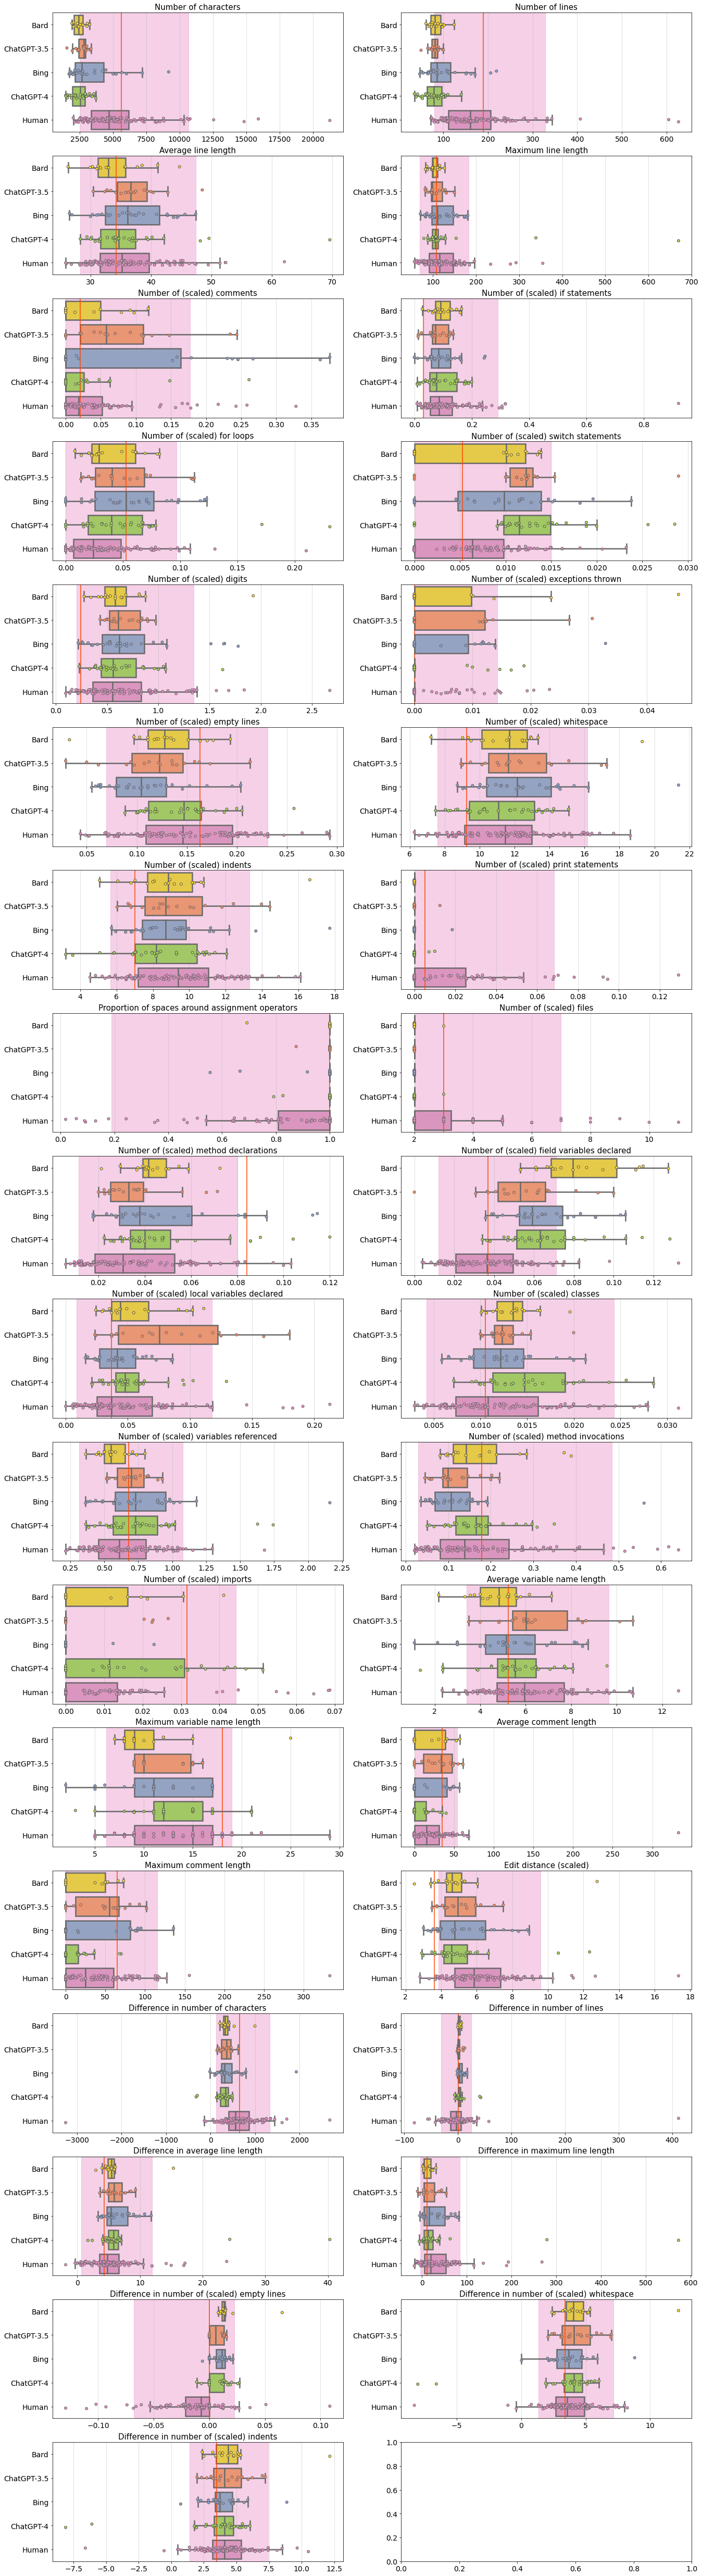

In [10]:
## SPECIFY THE SOLUTION

solution = 24

########

# create the plots
fig, axes = plt.subplots(ncols=2, nrows=18, figsize=(22, 90))

# plot each of the continuous features
for ax, aspect in zip(axes.reshape(-1), aspects):
    
    # create the boxplots
    sns.boxplot(data=data, 
                x=aspect, 
                y="source", 
                linewidth=2.5, 
                zorder=5, 
                palette=colours,
                showfliers=False,
                ax=ax, 
                order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"],
                capprops={"color":"dimgray"}, 
                boxprops={'edgecolor':'dimgray'}, 
                medianprops={'color':'dimgray'}, 
                whiskerprops={'color':'dimgray'})
    
    # overlay with the stripplots
    sns.stripplot(data=data, 
                  x=aspect, 
                  y="source", 
                  hue="source", 
                  palette=colours, 
                  edgecolor='gray', 
                  linewidth=1, 
                  zorder=10,
                  order=["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"], 
                  ax=ax)
    
    # adjust the labels
    ax.set_axisbelow(True) 
    ax.grid(alpha=0.5, axis="x")
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_title(aspect, fontsize=15)
    ax.get_legend().remove()
    
    # create a band for the confidence interval
    ax.axvspan(np.percentile(data[data["source"]=="Human"][aspect], 5), np.percentile(data[data["source"]=="Human"][aspect], 95),
               alpha=0.4, color=colours["Human"], zorder=-5)
    
    # mark a specific solution
    if solution != None:
        ax.axvline(specific_solutions.loc[solution, aspect], color="orangered", label=specific_solutions.iloc[solution]["source"] + "_" + specific_solutions.iloc[solution]["name"])

## Differences on two features

In [11]:
# sort the variables in the selection by how well they classify the data
all_features = list(data.columns[6:-1])
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(data[all_features].values, 
                                                                        data["binary_source"], 
                                                                        test_size=0.3, 
                                                                        random_state=0)
full_forest = RandomForestClassifier(random_state=0, 
                                     max_features=1, 
                                     n_estimators=160, 
                                     max_depth=10)
full_forest.fit(X_train_full, y_train_full)
all_features = list(pd.Series(full_forest.feature_importances_, index=all_features).sort_values(ascending=False).index)

In [17]:
# additional data needed for the visualisation
markers = ["plus", "hex", "triangle", "square", "circle"]
category = ["Bard", "ChatGPT-3.5", "Bing", "ChatGPT-4", "Human"]
db_colours = {0:"#bae083", 1:"#a2457d"}
cat_colours = ["#e5c949", "#e99675", "#95a3c3", "#a2c865", "#db96c0"]
starting_x = "Number of lines"
starting_y = "Number of (scaled) field variables declared"

In [13]:
# find the decision boundary meshes for every combination of pairs of variables
all_meshes = []
# find the acccuracy of the model on each pair of variables
all_accuracy = dict()

# find all permutations of pairs of variables - the order is relevant, as the mesh will be mirrored
for var1 in tqdm(all_features):
    for var2 in all_features:
        
        # use only the data for the given 2 variables to train a random forest classifier
        X = data[[var1, var2]].values
        y = data["binary_source"].values
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.4, 
                                                            random_state=0)
        forest = RandomForestClassifier(random_state=0, 
                                        max_features="sqrt", 
                                        n_estimators=180, 
                                        max_depth=5)
        forest.fit(X_train, y_train)

        # find the boundary edges for the mesh 
        min_var1, max_var1 = X[:, 0].min(), X[:, 0].max()
        min_var2, max_var2 = X[:, 1].min(), X[:, 1].max()

        # define the grid for the mesh
        mesh = np.meshgrid(np.linspace(min_var1, max_var1, 80), np.linspace(min_var2, max_var2, 85))

        # defining the colours/predictions on the mesh
        predictions = forest.predict(np.c_[mesh[0].ravel(), mesh[1].ravel()])
        predictions = predictions.reshape(mesh[0].shape)    

        # combining the mesh positions and colours/predictions
        mesh = pd.DataFrame(np.c_[mesh[0].ravel(), 
                                  mesh[1].ravel(), 
                                  predictions.ravel()], 
                            columns=[f"{var1}_{var2}_xx", f"{var1}_{var2}_yy", f"{var1}_{var2}_pred"])
        mesh[f"{var1}_{var2}_colours"] = mesh[f"{var1}_{var2}_pred"].map(db_colours)
        
        # saving the mesh to the overall list
        all_meshes.append(mesh)
        
        # save the accuracy of the model
        all_accuracy[f"{var1}_{var2}"] = "{:.1f}".format(accuracy_score(y_test, forest.predict(X_test))*100)
        
all_meshes = pd.concat(all_meshes, axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [05:03<00:00,  8.67s/it]


In [18]:
# store the data in column data source format for Bokeh
cds_data = ColumnDataSource(data)
cds_mesh = ColumnDataSource(all_meshes)

# create the initial figure
plot = figure(plot_width=600, 
              plot_height=600, 
              tools=["tap", "save", "reset"],
              x_axis_label=starting_x, 
              y_axis_label=starting_y)
click_desc = Div(text="""<div style='width: 600px; margin: 0 auto;'><p style='font-size: 15px; font-weight: bold; text-align: center;'>
                         Click on a point to see its associated code solution!</p></div>""")
db_desc = Div(text="<div style='width: 610px; font-size: 14px;'>The features are ordered by how well they classify the data into AI versus human written code.\
                                                  The accuracy of a classifier trained on the currently displayed features is shown under the legend.</div>")

# plot the decision boundaries
mesh = plot.square(source=cds_mesh, 
                   x=f"{starting_x}_{starting_y}_xx", 
                   y=f"{starting_x}_{starting_y}_yy", 
                   fill_color=f"{starting_x}_{starting_y}_colours", 
                   size=6, 
                   line_alpha=0, 
                   fill_alpha=0.2, 
                   name="Mesh")
mesh.nonselection_glyph = None

# plot the data points
scatterpoints = plot.scatter(source=cds_data, 
                             x=starting_x, 
                             y=starting_y, 
                             size=12, 
                             line_width=0.5, 
                             line_color="#686768", 
                             legend_field="source", 
                             name="Points",
                             marker=factor_mark(field_name="source", 
                                                markers=markers, 
                                                factors=category),
                             color=factor_cmap(field_name="source", 
                                               palette=cat_colours, 
                                               factors=category))

# create a label for the accuracy of the classifier being shown
accuracy_label = Label(x=390, 
                       y=340, 
                       x_units="screen", 
                       y_units="screen", 
                       text_font_size="14px", 
                       text_font_style="bold", 
                       text_baseline="bottom",
                       text=all_accuracy[f"{starting_x}_{starting_y}"] + "% accuracy", 
                       render_mode="canvas")
plot.axis.axis_label_text_font_style = 'normal'

db_label_1 = Label(x=385, 
                   y=385, 
                   x_units="screen", 
                   y_units="screen",
                   text="AI Predictions", 
                   render_mode="canvas",
                   border_line_alpha=0.2,
                   background_fill_alpha=0.4,
                   text_font_size="14px",
                   background_fill_color=db_colours[0])

db_label_2 = Label(x=385, 
                   y=365, 
                   x_units="screen", 
                   y_units="screen",
                   text="Human Predictions", 
                   render_mode="canvas",
                   border_line_alpha=0.2,
                   background_fill_alpha=0.2,
                   text_font_size="14px",
                   background_fill_color=db_colours[1])

# click to show the code text
code_text = Div()
callback_click = CustomJS(args=dict(source=cds_data, 
                                    div=code_text), 
    code="""
    var index = source.selected.indices
    if (index.length == 0) {
        div.text = "";
        div.style = {};
    }
    else {
        div.text = source.data['name'][index[0]] + '<pre>' + source.data['code'][index[0]] + '</pre>';
        div.style = {'border': '1px solid black', 'padding': '10px'};
    }
    """)
cds_data.selected.js_on_change('indices', callback_click)

# select the x and y variables
select_x = Select(title="Choose the feature for the x-axis:", 
                  value=starting_x, 
                  options=all_features)
select_y = Select(title="Choose the feature for the y-axis:", 
                  value=starting_y, 
                  options=all_features)
callback_select = CustomJS(args=dict(scatterpoints_renderer=scatterpoints, 
                                     mesh_renderer=mesh,
                                     x_select=select_x, 
                                     y_select=select_y, 
                                     accuracy_label=accuracy_label, 
                                     accuracy_dict=all_accuracy,
                                     xaxis=plot.xaxis[0], 
                                     yaxis=plot.yaxis[0]),             
    code="""
    scatterpoints_renderer.glyph.x = {field: x_select.value};
    scatterpoints_renderer.glyph.y = {field: y_select.value};
    
    xaxis.axis_label = x_select.value;
    yaxis.axis_label = y_select.value;
    
    var current_vars = x_select.value + "_" + y_select.value;
    var current_xx = current_vars + "_xx";
    var current_yy = current_vars + "_yy";
    var current_colour = current_vars + "_colours";
    mesh_renderer.glyph.x = {field: current_xx};
    mesh_renderer.glyph.y = {field: current_yy};
    mesh_renderer.glyph.fill_color = {field: current_colour};
    
    accuracy_label.text = accuracy_dict[current_vars] + "% accuracy";
    
""")

select_x.js_on_change('value', callback_select)
select_y.js_on_change('value', callback_select)

# layout of the whole plot
layout = row(column(select_x, select_y, db_desc, plot, click_desc), code_text)
for label in [accuracy_label, db_label_1, db_label_2]:
    plot.add_layout(label)
show(layout)

## Interactions between features and test passing rates

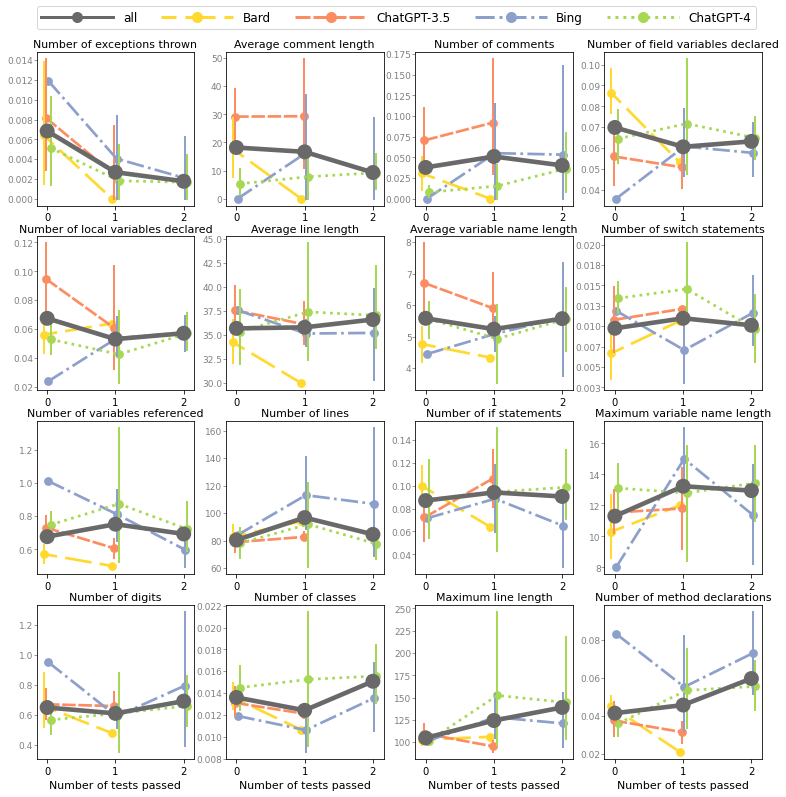

In [19]:
# create the plot
fig, axes = plt.subplots(ncols=4, 
                         nrows=4, 
                         figsize=(13, 13))
for ax, aspect in zip(axes.reshape(-1), int_aspects):
    
    # plot the grouped data
    sources = sns.pointplot(data=interactions_data, 
                            x="num_tests_passed", 
                            y=aspect, 
                            hue="source",
                            palette=colours, 
                            errwidth=2, 
                            dodge=True, 
                            ax=ax,
                            linestyles=[(5, (10, 3)), (0, (5, 1)), "dashdot", "dotted"])
    
    # plot the overall data 
    overall = sns.pointplot(data=interactions_data, 
                            x="num_tests_passed", 
                            color="dimgray", 
                            scale=1.7, 
                            errorbar=None, 
                            y=aspect, 
                            ax=ax)
    sns.scatterplot(data=interactions_data, 
                    x="num_tests_passed", 
                    color="dimgray", 
                    ax=ax)
    overall.collections[4].set_zorder(100)
    for line in overall.lines:
        line.set_zorder(100)
    
    # set the labels
    ax.set_title(aspect, fontsize=11, pad=4.5)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.tick_params(axis="y",
                   colors="gray", 
                   labelsize=9)
    ax.tick_params(axis="y", 
                   which='major', 
                   pad=0)
    ax.tick_params(axis="x",
                   labelsize=10)
    # set axis labels for the outer plots
    if aspect in ["Number of switch statements", "Number of exceptions thrown"]:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    if aspect in int_aspects[-4:]:
        ax.set_xlabel("Number of tests passed", fontsize=11)

    # remove the legend from each small plot
    ax.get_legend().remove()

# create a custom legend
plt.legend(numpoints=1, 
           handlelength=6, 
           loc=(-3.6, 4.75), 
           ncol=5, 
           fontsize=12,
           handles=[Line2D([], [], label='all', color="dimgray", linewidth=3, linestyle="solid", marker='o', markersize=10),
                    Line2D([], [], label='Bard', color=colours["Bard"], linewidth=3, linestyle=(5, (10, 3)), marker='o', markersize=10), 
                    Line2D([], [], label='ChatGPT-3.5', color=colours["ChatGPT-3.5"], linewidth=3, linestyle=(0, (5, 1)), marker='o', markersize=10), 
                    Line2D([], [], label='Bing', color=colours["Bing"], linewidth=3, linestyle="dashdot",marker='o', markersize=10),
                    Line2D([], [], label='ChatGPT-4', color=colours["ChatGPT-4"], linewidth=3, linestyle="dotted", marker='o', markersize=10)]);